I’ve been using linear models a lot, so this time I want to see how a Decision Tree behaves on the wine dataset. I’ll first fit a logistic regression baseline (simple, explainable), then switch to a tree, visualize splits, and add pruning. Along the way I’ll check what actually helps or hurts generalizatio

# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

# Load and inspect data

In [2]:
wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [4]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


At this point, we can know that the scale alcohol, sugar, pH are different. So we need to use StandardScaler of scikit learn to normalize the data. But before that, lets first extract the X and y from the pandas dataframe and split to train and test set.

# Train/Test Split

In [5]:
X = wine[['alcohol', 'sugar', 'pH']]
y = wine['class']

In [6]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

# By default, 25% of the total set is allocated to test set. But since we have sufficient amount of sample, lets split 20% to the test set

In [7]:
print(train_X.shape, test_X.shape)

(5197, 3) (1300, 3)


# Baseline: Logistic Regression (scaled)

In [8]:
# Scaling(normalizing) the data
ss = StandardScaler()
train_scaled = ss.fit_transform(train_X)
test_scaled = ss.transform(test_X)

At this point, preprocessing is all done. So now lets move on to logistic regression.

In [9]:
lr = LogisticRegression()
lr.fit(train_scaled, train_y)

print(lr.score(train_scaled, train_y))
print(lr.score(test_scaled, test_y))

0.7808350971714451
0.7776923076923077


In [10]:
print(lr.coef_, lr.intercept_)

[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


As displayed, the score of both train and test set is not high enough, which is underfitted. We can try changing the regulatory parameters or other algorithms of the 'solver' parameter, or add polynomial features (but not today).

At this point, LR is a decent baseline but not great, since it’s linear by design. Maybe a tree captures nonlinearity better.

# Decision Tree

In [11]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(train_scaled, train_y)

print(dt.score(train_scaled, train_y))
print(dt.score(test_scaled, test_y))

0.996921300750433
0.8592307692307692


As displayed, the score of the training set is high enough, but the test isn't, which we can say the model is overfitted.

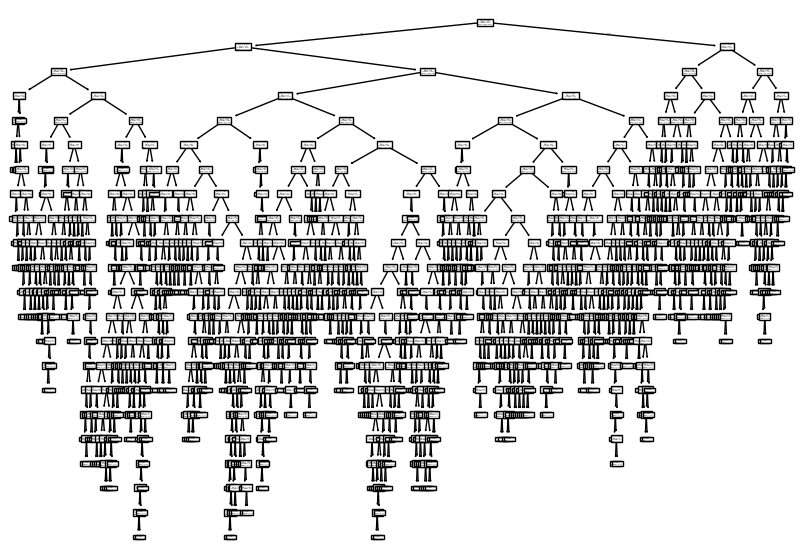

In [12]:
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

Since this tree is too complex, lets limit the depth of the tree. By adjusting the parameters inside the dt class, you can make it easier to read.

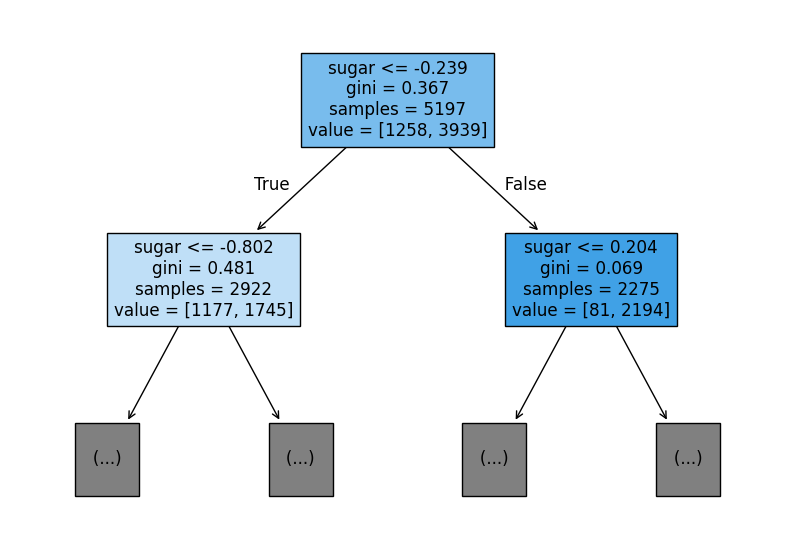

In [13]:
plt.figure(figsize = (10,7))
plot_tree(dt, max_depth = 1, filled = True,
          feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

Interpretation:

The root node asks whether the sugar is less than -0.239. If True, moves to the left node, if False, moves to the right node. 
There are total 1258 negative class, which is red wine and total 3939 positive class which is white wine, in the root node.

The left node asks whether the sugar is less than -0.802. If True, moves to the left, and if False, moves to the right.
1177 negative classes and 1745 negative classes show that the right node has more positive classes now. 

The 'gini' means the gini impurity, calculated by the sum of (negative class ratio)^2 and (positive class ratio)^2 subtracted by 1. 

The impurity difference of the parent and child node is called 'information gain'. The tree algorithm divides data to maximize the information gain. Another impurity standard is entropy, which uses the log2 instead of squared for the ratio.

# Alternative pruning: min_impurity_decrease

Depth is one way, and another is to stop splitting unless the impurity reduction is big enough. I’ll try a small threshold.

In [14]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dt.fit(train_scaled, train_y)

print(dt.score(train_scaled, train_y))
print(dt.score(test_scaled, test_y))

0.8454877814123533
0.8415384615384616


The score of the train set has decreased but the test set remains almost the same. Lets plot is now.

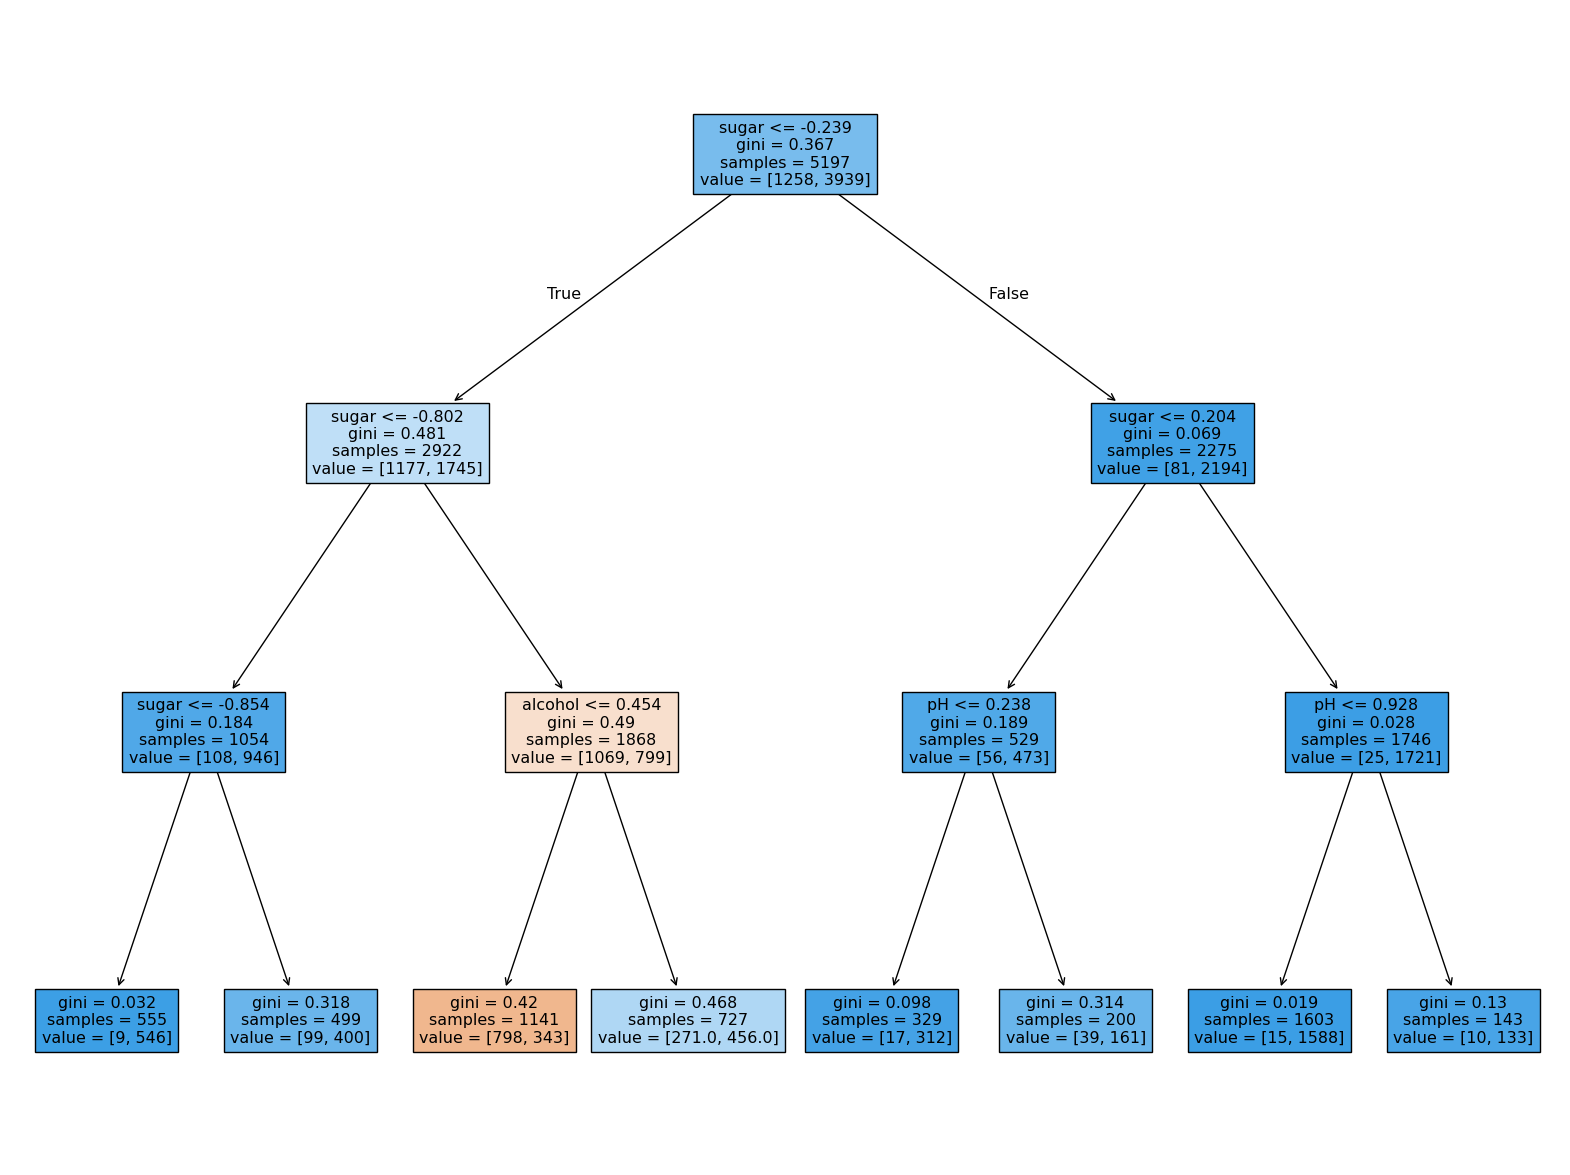

In [15]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

In [16]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dt.fit(train_X, train_y)

print(dt.score(train_X, train_y))
print(dt.score(test_X, test_y))

0.8454877814123533
0.8415384615384616


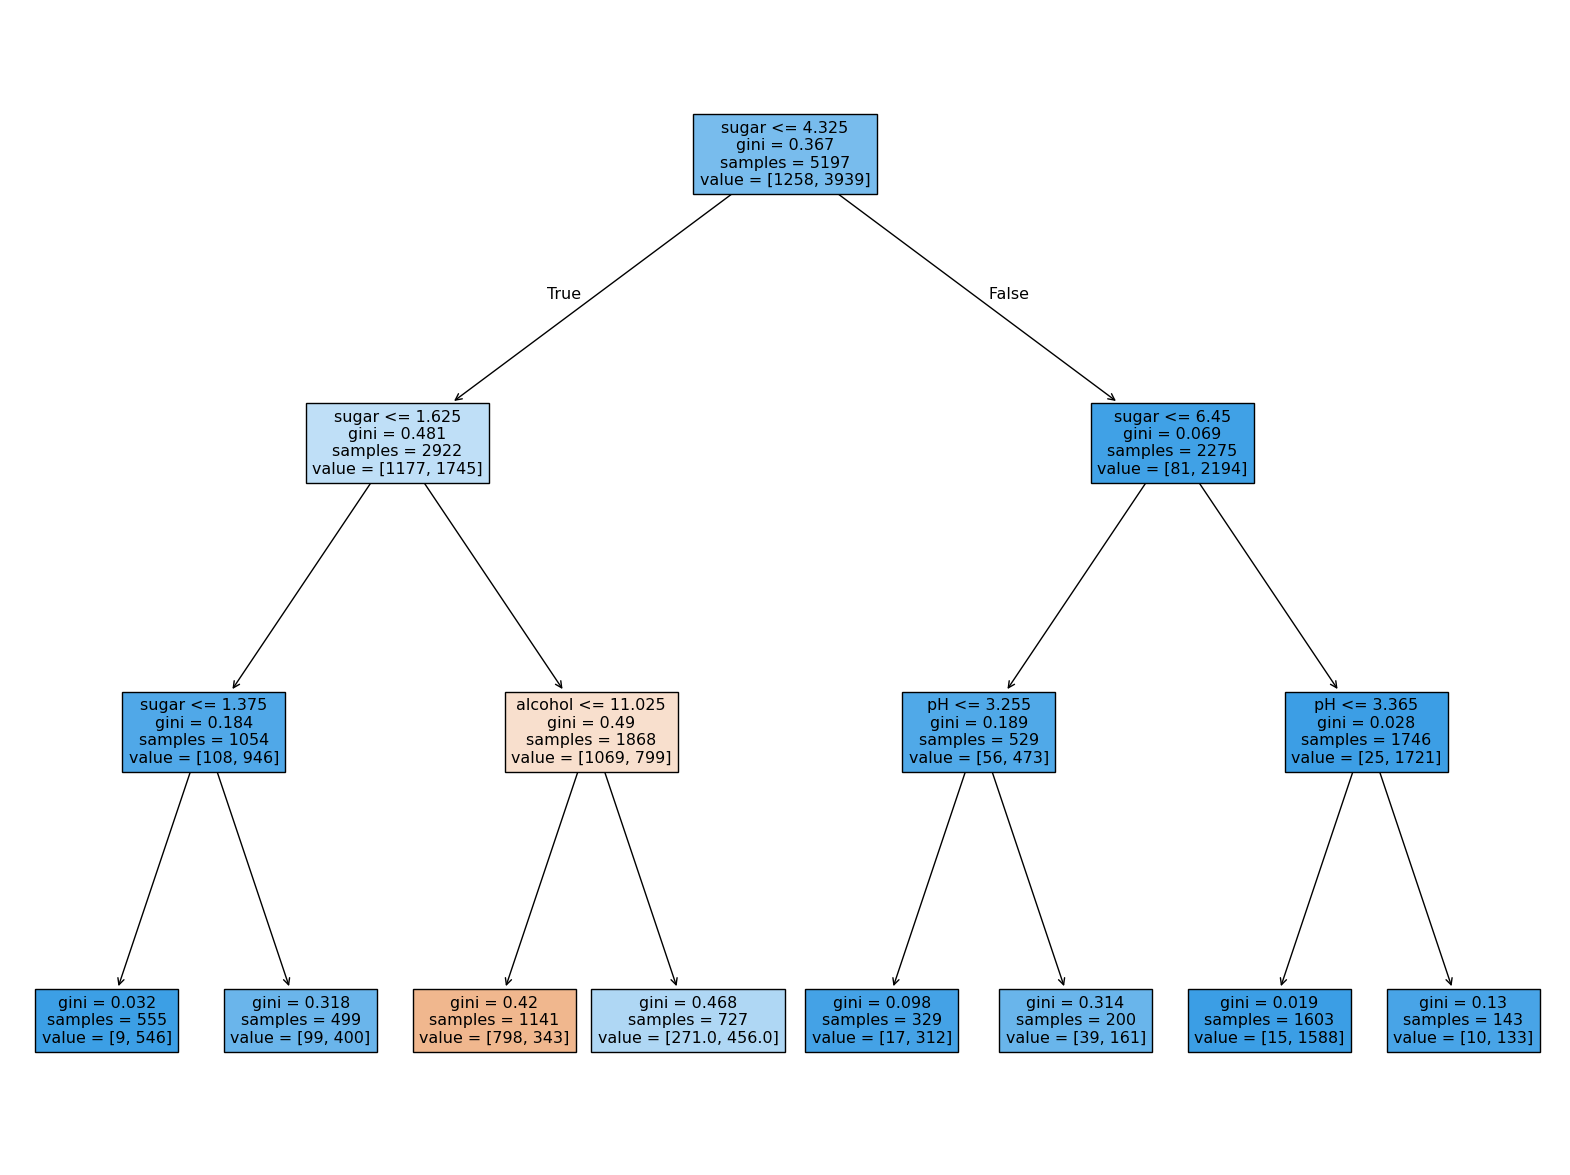

In [17]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

In [18]:
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


Here, we can see 'sugar' has the highest feature importance, which makes sense why the tree used it as a feature to split nodes at the root and depth 1. 

# What I learned

Switching from a linear baseline to a tree made the bias variant and trade off obvious. The unpruned tree overfit immediately, but once I added pruning either with max_depth or min_impurity_decrease, the test accuracy stabilized and surpassed logistic regression. Logistic regression explains through coefficients, while the decision tree explains through explicit split rules. For this wine dataset, sugar is by far the most informative feature, and a small number of splits captures most of the signal. I’ll keep the pruned tree as my default here and only relax constraints if I have strong evidence that the extra depth helps generalization.